# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## Preparação 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head(-5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34


In [4]:
# Como estamos interessados na próxima hora, faremos um resample para hora
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [6]:
data.index.is_monotonic

True

De acordo com as informações dos dados, não existem dados nulos para excluir ou preencher e nem dados que não fazem sentido dentro do nosso contexto. Portanto seguiremos para criação de características para treinar nosso modelo.

In [7]:
decomposed = seasonal_decompose(data)

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    decomposed = seasonal_decompose(data)
    data['trend'] = decomposed.trend
    data['seasonal'] = decomposed.seasonal
    data['residual'] = decomposed.resid
    data['month'] = data.index.month
    data['week'] = data.index.isocalendar().week
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1,):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(data, 4, 12)

In [10]:
data.head()

,num_orders,trend,seasonal,residual,month,week,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,60.248112,NaN,3,9,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,20.177074,NaN,3,9,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,28.982743,NaN,3,9,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,17.885407,NaN,3,9,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,2.791145,NaN,3,9,1,3,4,66.0,71.0,85.0,124.0,NaN


## Análise

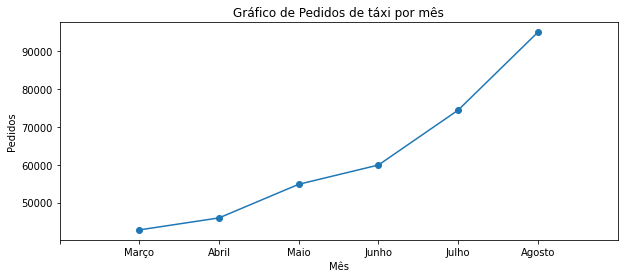

In [11]:
months = ['Dezembro','Janeiro', '', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto']
orders_by_month = data.groupby('month')['num_orders'].sum().reset_index()

plt.subplots(figsize=(10,4))
plt.plot(orders_by_month['month'], orders_by_month['num_orders'], marker='o', linestyle='-')
plt.title('Gráfico de Pedidos de táxi por mês')
plt.xlabel('Mês')
plt.xticks(range(9), months)
plt.xlim(2,9)

plt.ylabel('Pedidos')

plt.show()


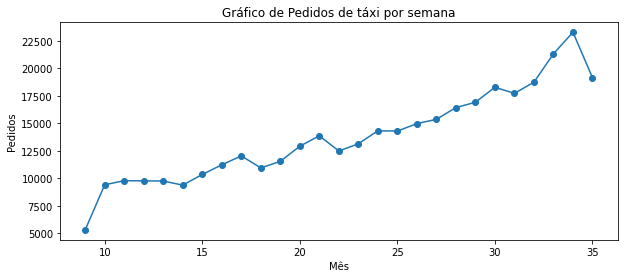

In [12]:
orders_by_week = data.groupby('week')['num_orders'].sum().reset_index()

plt.subplots(figsize=(10,4))
plt.plot(orders_by_week['week'], orders_by_week['num_orders'], marker='o', linestyle='-')
plt.title('Gráfico de Pedidos de táxi por semana')
plt.xlabel('Mês')
#plt.xticks(range(9), months)
#plt.xlim(2,9)

plt.ylabel('Pedidos')

plt.show()


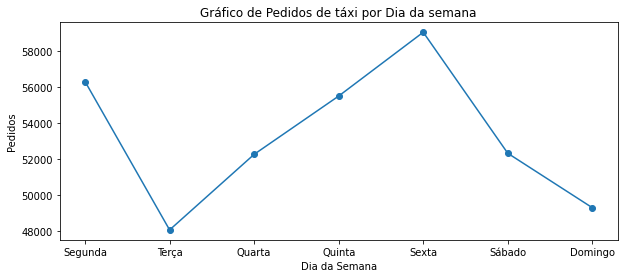

In [13]:
orders_by_dayofweek = data.groupby('dayofweek')['num_orders'].sum().reset_index()
dayofweek = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']

plt.subplots(figsize=(10,4))
plt.plot(orders_by_dayofweek['dayofweek'], orders_by_dayofweek['num_orders'], marker='o', linestyle='-')

plt.title('Gráfico de Pedidos de táxi por Dia da semana')
plt.xlabel('Dia da Semana')

plt.xticks(range(7), labels=dayofweek)

plt.ylabel('Pedidos')

plt.show()

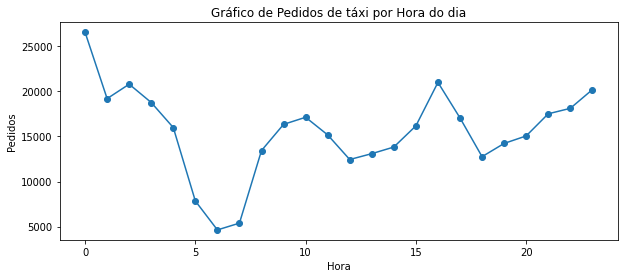

In [14]:
orders_by_hour = data.groupby('hour')['num_orders'].sum().reset_index()

plt.subplots(figsize=(10,4))
plt.plot(orders_by_hour['hour'], orders_by_hour['num_orders'], marker='o', linestyle='-')

plt.title('Gráfico de Pedidos de táxi por Hora do dia')
plt.xlabel('Hora')

plt.ylabel('Pedidos')

plt.show()

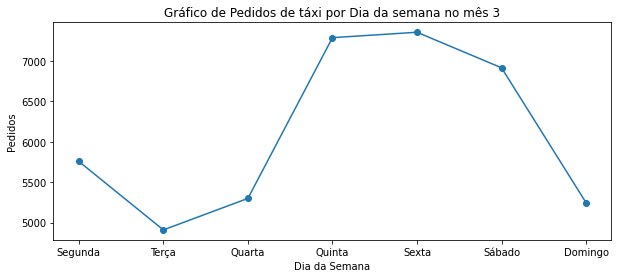

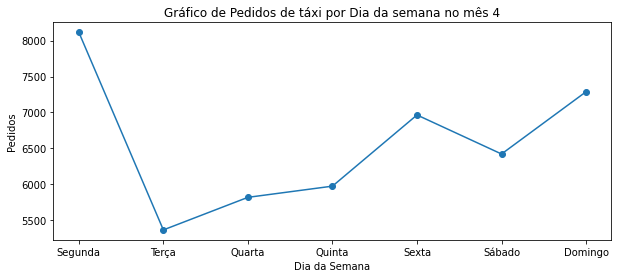

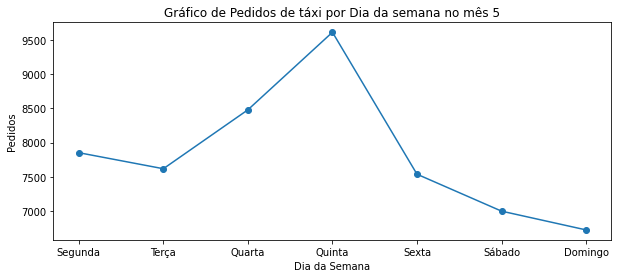

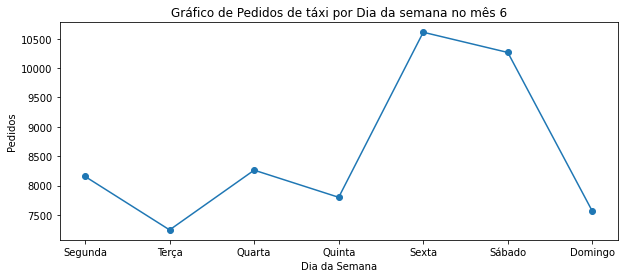

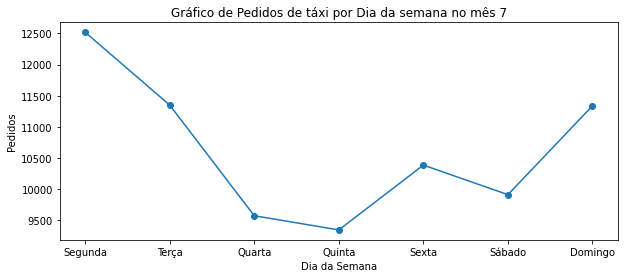

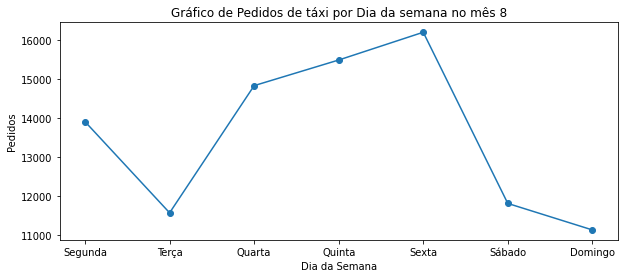

In [15]:
orders_by_dayofweek_month = data.groupby(['month', 'dayofweek'])['num_orders'].sum().reset_index()

for month in range(3,9,1):
    aux = orders_by_dayofweek_month[orders_by_dayofweek_month['month'] == month]
    plt.subplots(figsize=(10,4))
    plt.plot(aux['dayofweek'], 
             aux['num_orders'], marker='o', linestyle='-')

    plt.title(f'Gráfico de Pedidos de táxi por Dia da semana no mês {month}')
    plt.xlabel('Dia da Semana')

    plt.xticks(range(7), labels=dayofweek)

    plt.ylabel('Pedidos')

    plt.show()

Ao analisar os gráficos podemos perceber os seguintes pontos: <br>
1) Sazonalidade nos dias da semana , sendo que, na maioria dos casos terça é o dia com menor procura, e sexta o dia com número de pedidos. <br>
2) Durante o dia, o período da manhã possui pouca procura, que tem pico no início da madrugada, e com boa procura durante o almoço e final de tarde também. <br>
3) E a tendência de aumento de pedido em cada novo mês.

Criamos as colunas 'trend', 'seasonal' e 'residual' para que essas características sejam consideradas ao prever a procura da próxima hora.

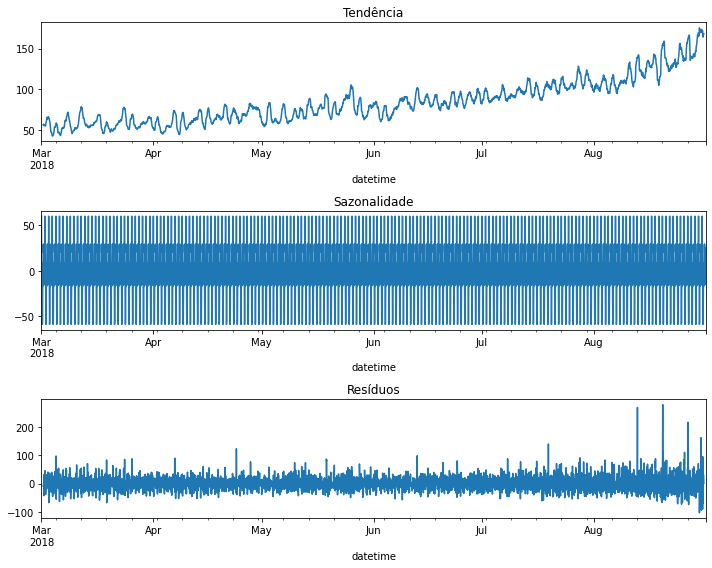

In [16]:
plt.figure(figsize=(10, 8))
plt.subplot(311)

#decomposed.trend.plot(ax=plt.gca())
data['trend'].plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)

#decomposed.seasonal.plot(ax=plt.gca())
data['seasonal'].plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)

#decomposed.resid.plot(ax=plt.gca())
data['residual'].plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()

## Treinamento

In [17]:
# Criar dicionário que vai armazenar os valores das métricas REQM dos diferentes modelos
reqms = {
    'REQM':[]
}

In [18]:
# Dividir os dados em treino e teste e excluir os valores nulos

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [19]:
# Função para criar o grid do modelo, medir o REQM e retornar o REQM
def hyper_tuning_reqm(model, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, verbose=0, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    pred_values = grid.predict(X_test)

    reqm = mean_squared_error(y_test, pred_values)**0.5
    
    return reqm
    

### Regressão Linear

In [20]:
transformer_mas = MaxAbsScaler().fit(data.drop('num_orders', axis=1).to_numpy())

df_scaled = data.copy()
df_scaled.loc[:, X_train.columns] = transformer_mas.transform(data.drop('num_orders', axis=1).to_numpy())


In [21]:
train_mas, test_mas = train_test_split(df_scaled, shuffle=False, test_size=0.1)
train_mas = train_mas.dropna()
test_mas = test_mas.dropna()

X_train_mas = train_mas.drop('num_orders', axis=1)
y_train_mas = train_mas['num_orders']
X_test_mas = test_mas.drop('num_orders', axis=1)
y_test_mas = test_mas['num_orders']

In [22]:
# Regressão com MaxAbsScaler
lr_model = LinearRegression()

lr_model.fit(X_train_mas, y_train_mas)

lr_pred_values = lr_model.predict(X_test_mas)

reqm = mean_squared_error(y_test_mas, lr_pred_values)**0.5
reqm

2.1292268795683299e-13

In [23]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

In [24]:
train_scaled, test_scaled = train_test_split(data_scaled, shuffle=False, test_size=0.1)
train_scaled = train_scaled.dropna()
test_scaled = test_scaled.dropna()

X_train_scaled = train_scaled.drop('num_orders', axis=1)
y_train_scaled = train_scaled['num_orders']
X_test_scaled = test_scaled.drop('num_orders', axis=1)
y_test_scaled = test_scaled['num_orders']

In [25]:
# Regressão com StandardScaler
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train_scaled)

lr_pred_values = lr_model.predict(X_test_scaled)

reqm = mean_squared_error(y_test_scaled, lr_pred_values)**0.5
reqm

3.281147133620194e-15

In [26]:
# Regressão sem Scaler
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_pred_values = lr_model.predict(X_test)

reqm = mean_squared_error(y_test, lr_pred_values)**0.5
formatted_reqm = '{:.16f}'.format(reqm)
reqms['REQM'].append(formatted_reqm)
print("REQM para o conjunto de teste:", formatted_reqm)

REQM para o conjunto de teste: 0.0000000000000371


### Floresta aleatória

In [27]:
rf_model = RandomForestRegressor()
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [12345]
}

reqm = hyper_tuning_reqm(rf_model, rf_params, X_train, y_train, X_test, y_test)
formatted_reqm = '{:.4f}'.format(reqm)
reqms['REQM'].append(formatted_reqm)
print("REQM para o conjunto de teste:", formatted_reqm)

REQM para o conjunto de teste: 38.6970


### CatBoost

In [28]:
cb_model = CatBoostRegressor()
cb_params = {
    'depth': [2, 4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [50, 100],
    'random_state': [12345],
    'verbose': [0]
}

reqm = hyper_tuning_reqm(cb_model, cb_params, np.array(X_train), np.array(y_train), np.array(X_test), y_test)
formatted_reqm = '{:.4f}'.format(reqm)
reqms['REQM'].append(formatted_reqm)
print("REQM para o conjunto de teste:", formatted_reqm)

REQM para o conjunto de teste: 18.3797


### LightGBM

In [29]:
lgbm_model = lgb.LGBMRegressor()
lgbm_params = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1],
    'random_state': [12345]
}

reqm = hyper_tuning_reqm(lgbm_model, lgbm_params, np.array(X_train), np.array(y_train), np.array(X_test), y_test)
formatted_reqm = '{:.4f}'.format(reqm)
reqms['REQM'].append(formatted_reqm)
print("REQM para o conjunto de teste:", formatted_reqm)

REQM para o conjunto de teste: 17.8721


### XGBoost

In [30]:
xgb_model = xgb.XGBRegressor()
xgb_params = {
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'max_depth': [3, 4],
    'eta': [0.05, 0.1],
    'random_seed': [12345],
    'verbosity': [0]
}

reqm = hyper_tuning_reqm(xgb_model, xgb_params, np.array(X_train), np.array(y_train), np.array(X_test), y_test)
formatted_reqm = '{:.4f}'.format(reqm)
reqms['REQM'].append(formatted_reqm)
print("REQM para o conjunto de teste:", formatted_reqm)

REQM para o conjunto de teste: 18.0670


## Testando

In [31]:
# Criando Dataframe com as métricas dos modelos testados
index = ['Linear Regression', 'Random Forest', 'CatBoost', 'LightGBM', 'XGBoost']
df_reqm = pd.DataFrame(reqms, index=index)
df_reqm

,REQM
Linear Regression,0.0000000000000371
Random Forest,38.6970
CatBoost,18.3797
LightGBM,17.8721
XGBoost,18.0670


Utilizando os modelos Regressão linear, Floresta Aleatória, CatBoost, LightGBM e XGBOost para prever os número de pedidos e tendo 48 como valor limite para o REQM, todos os modelos atenderam satisfatoriamente à exigência, com a floresta aleatória sendo o pior modelo, CatBoost, LightGBM e XGBoost ficaram bem próximos um do outro com ótimos valores entre 17 e 18.4

# Revisão da checklist

- [x]  O Jupyter Notebook está aberto.

- [x]  O código está livre de erros
- [x]  As células com o código foram organizadas em ordem de execução.
- [x]  Os dados foram baixados e preparados

- [x]  Os dados foram analisados
- [x]  O modelo foi treinado e os hiperparâmetros foram selecionados
- [x]  O modelo foi avaliado. Uma conclusão foi fornecida

- [x]  O REQM para o conjunto de teste não é maior que 48